In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv
import pandas as pd
import scipy.optimize as sp
import time

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

%run ../aux_funcs.py
%run ../RSRG_bdry_class.py
%run ../bdry_aux_funcs.py

In [2]:
log_file = pd.read_csv("bdry_log_file.csv")
ts_list = log_file['ts'].tolist()
log_file

,L,steps,w_blk,w_bdry,w_mixed,n_runs,ts
0,30,892,2.6,2.6,2.6,30,1678748898
1,30,892,2.2,2.6,2.6,30,1678749434
2,30,892,2.4,2.6,2.6,30,1678749560
3,30,892,2.8,2.6,2.6,30,1678749688
4,30,892,3.0,2.6,2.6,30,1678749823
...,...,...,...,...,...,...,...
59,70,4860,3.0,0.1,2.6,60,1678815620
60,70,4860,3.2,0.1,2.6,60,1678817618
61,70,4860,3.4,0.1,2.6,60,1678822613
62,70,4860,3.6,0.1,2.6,60,1678825180


In [ ]:
L_list  = [40, 60, 70, 80]

for L in L_list:
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w_blk'].tolist()
    n_runs_list = fixed_length_slice['n_runs'].tolist()

    p_perc_clust = []
    p_perc_clust_err = []
    c_list = []
    #color_dict = {50:'blue', 60:'red', 40:'green'}

    for index, ts in enumerate(ts_list):

        with open("IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []
        perc_cluster = []

        for core_pair in clust_list_final:
            clust_list_temp = core_pair[0]
            reverse_list_temp = core_pair[1]
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        perc_prob_temp = np.array([check_percolation_strip(clust, L, int(L/4)) for clust in clust_dict_list])

        p_perc_clust.append(perc_prob_temp.mean())
        p_perc_clust_err.append(perc_prob_temp.std()/np.sqrt(n_runs_list[index] - 1))
        c_list.append(c_dict[L])
   
    #plt.scatter(w_vals, p_perc_clust, c=c_list, label="L="+str(L))
    #plt.errorbar(w_vals, p_perc_clust, yerr=p_perc_clust_err, c=c_dict[L], label="L="+str(L))
    
    sorted_y = np.array([x for _,x in sorted(zip(w_vals,p_perc_clust))])
    sorted_y_err = np.array([x for _,x in sorted(zip(w_vals,p_perc_clust_err))])
    sorted_x = np.array(sorted(w_vals))
    plt.errorbar(sorted_x, sorted_y, c=c_dict[L], label="L="+str(L), marker='o', yerr=sorted_y_err)
    
    popt, pcov = curve_fit(sigmoid_func, sorted_x, sorted_y)
    #x_lin = np.linspace(1.4, 3.8, 200)
    #plt.plot(x_lin, sigmoid_func(x_lin, *popt))
    

plt.legend()
plt.ylabel("Percolation probability")
plt.xlabel("Width of coupling parameter")
plt.title("Percolation Transition")

In [26]:
ts = 1678772088
L = 50
n_runs = 30

with open("IsingB_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)

#print(input_dict)
clust_dict_list, reverse_dict_list = [], []
perc_cluster = []

for core_pair in clust_list_final:
    clust_list_temp = core_pair[0]
    reverse_list_temp = core_pair[1]
    clust_dict_list+=clust_list_temp
    reverse_dict_list+=reverse_list_temp
    
mean_corr_mat = np.zeros(shape=(L*L,L*L))
for instance in range(len(reverse_dict_list)):
    mean_corr_mat += generate_corr_matrix_alt2(clust_dict_list[instance], reverse_dict_list[instance], L)

mean_corr_mat = mean_corr_mat/n_runs

14.166684037311004 0.5317137407112235


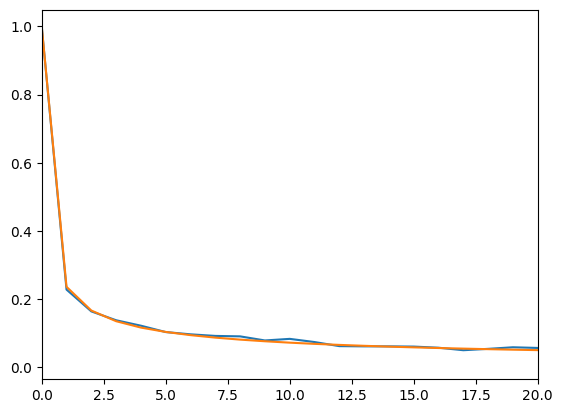

In [27]:
y_vals = np.arange(L)
corr_function = np.zeros(shape=(L))

for y in range(L):
    for x in range(L):
        corr_function[y] += mean_corr_mat[index_map(0,x,L), index_map(y,x,L)]
    
plt.plot(y_vals, corr_function/L)

popt, pcov = curve_fit(power_law, y_vals,corr_function/L)

plt.plot(y_vals, power_law(y_vals, *popt))
plt.xlim(0, 20)
print(*popt)

In [23]:
def power_law(x, scale, power):
    return 1/(1+x*scale)**power

In [3]:
def generate_corr_matrix(reverse_dict, L):
    vect = np.zeros(shape=(L*L, L*L), dtype=bool)
    for key in reverse_dict:
        if reverse_dict[key] is None: continue
        vect[key,reverse_dict[key]] = True
    return np.einsum('ab,ac->bc', vect, vect)

def generate_corr_matrix_alt(clust_dict, L):
    corr_mat_alt = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        for j in range(i, L*L):
            corr_mat_alt[i,j] = (clust_dict[i]==clust_dict[j])
    corr_mat_alt = corr_mat_alt.T + corr_mat_alt 
    return corr_mat_alt

def generate_corr_matrix_alt2(clust_dict, reverse_dict, L):
    #Fastest
    corr_mat = np.zeros(shape=(L*L, L*L), dtype=bool)
    for i in range(L*L):
        corr_mat[i, reverse_dict[clust_dict[i]]] = True
    return corr_mat

In [18]:
t0 = time.time()
corr_mat_alt2 = generate_corr_matrix_alt2(clust_dict_list[0], reverse_dict_list[0], 70)
print(time.time()-t0)

0.012842416763305664
